In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import theano 
from theano import *
import matplotlib.pyplot as plt
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'


# Introduction

Mathematical models are used ubiquitously in a variety of science and engineering domains to model the time evolution of physical variables. These mathematical models are often described as ODEs that are characterised by model structure - the functions of the dynamical variables - and model parameters. However, for the vast majority of systems of practical interest it is necessary to infer both the model parameters and an appropriate model structure from experimental observations. This experimental data often appears to be scarce and incomplete. Furthermore, a large variety of models described as dynamical systems show traits of sloppiness (see [Gutenkunst et al., 2007](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.0030189)) and have unidentifiable parameter combinations. The task of inferring model parameters and structure from experimental data is of paramount importance to reliably analyse the behaviour of dynamical systems and draw faithful predictions in light of the difficulties posit by their complexities. Moreover, any future model prediction should encompass and propagate variability and uncertainty in model parameters and structure. Thus it is also important that the inference methods are equipped to quantify and propagate the aforementioned uncertainties from the model descriptions to model predictions. As a natural choice to handle uncertainty, at least in the parameters, Bayesian inference is increasingly used to fit ODE models to experimental data ([Mark Girolami, 2008](https://www.sciencedirect.com/science/article/pii/S030439750800501X)). However, due to some of the difficulties that I pointed above, fitting an ODE model using Bayesian inference is a challenging task. In this tutorial I am going to take up that challenge and will show how PyMC3 could be potentially used for this purpose. 

I must point out that model fitting (inference of the unknown parameters and/or structure) is just one of many crucial tasks that a modeller has to complete in order to gain a deeper understanding of a physical process. However, success in this task is crucial and this is where PyMC3 (and probabilistic programming in general) is extremely useful. The modeller can take full advantage of the variety of samplers and distributions provided by PyMC3 to automate inference.

In this tutorial I will focus on the fitting exercise, that is estimating the posterior distribution of the parameters given some noisy experimental time series. 

## Bayesian inference of the parameters of an ODE

I begin by first introducing the Bayesian framework for inference in a coupled non-linear ODE defined as 
\begin{equation}
\frac{d X(t)}{dt}=\boldsymbol{f}\big(X(t),\boldsymbol{\theta}\big)
\end{equation}
where $X(t)\in\mathbb{R}^K$ is the solution, at each time point, of the system composed of $K$ coupled ODEs - the state vector - and $\boldsymbol{\theta}\in\mathbb{R}^D$ is the parameter vector that we wish to infer. $\boldsymbol{f}(\cdot)$ is a non-linear function that models the dynamics. Also, in case of an initial value problem, let the matrix $\boldsymbol{X}(\boldsymbol{\theta}, \mathbf{x_0})$ denote the solution of the above system of equations at some specified time points for the parameters $\boldsymbol{\theta}$ and initial conditions $\mathbf{x_0}$.

Consider a set of noisy experimental observations $\boldsymbol{Y} \in \mathbb{R}^{T\times K}$ observed at $T$ experimental time points for the $K$ states. We can obtain the likelihood $p(\boldsymbol{Y}|\boldsymbol{X})$, where I use the symbol $\boldsymbol{X}:=\boldsymbol{X}(\boldsymbol{\theta}, \mathbf{x_0})$,  and combine that with a prior distribution $p(\boldsymbol{\theta})$ on the parameters, using the Bayes theorem, to obtain the posterior density as
\begin{equation}
p(\boldsymbol{\theta}|\boldsymbol{Y})=\frac{1}{Z}p(\boldsymbol{Y}|\boldsymbol{X})p(\boldsymbol{\theta}),
\end{equation}
where $Z=\int p(\boldsymbol{Y}|\boldsymbol{X})p(\boldsymbol{\theta}) d\boldsymbol{\theta} $ is the intractable marginal likelihood. Due to this intractability we resort to approximate inference and apply MCMC. 

For this tutorial we have chosen two ODEs: 
1. The [__Lotka-Volterra predator prey model__ ](http://www.scholarpedia.org/article/Predator-prey_model)
2. The [__Fitzhugh-Nagumo action potential model__](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model)

I will showcase two distinctive approaches, supported by PyMC3, for the estimation of unknown parameters in these models. 

## Lotka-Volterra predator prey model

 The Lotka Volterra model depicts an ecological system that is used to describe the interaction between a predator and prey species. This ODE given by
 \begin{aligned}
 	\frac{d x}{dt} &=\alpha x -\beta xy \\
 	\frac{d y}{dt} &=-\gamma y + \delta xy,
 \end{aligned}
 shows limit cycle behaviour and has been often used for benchmarking Bayesian inference algorithms. $\boldsymbol{\theta}=(\alpha,\beta,\gamma,\delta, x(0),y(0))$ is the set of unknown parameters that we wish to infer from experimental observations of the state vector $X(t)=(x(t),y(t))$ comprising the concentrations of the predator and the prey species respectively. $x(0), y(0)$ are the initial values of the states needed to solve the ODE, which is also an unknown quantity. The predator prey model has been recently used to demonstrate the applicability of the NUTS sampler, and the STAN ppl in general, for inference in ODE models. I will closely follow [this](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html) STAN tutorial and thus I will setup this model and associated inference problem (including the data) exactly as was done for STAN. Let me first write down the code to solve this ODE using the `scipy`'s `odeint`.

In [2]:
class LotkaVolterraModel(object):  
    def __init__(self, y0=None):
        self._y0 = y0

    def simulate(self, parameters, times): 
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]
        def rhs(y, t, p):
            X, Y = y
            dX_dt = alpha*X - beta*X*Y
            dY_dt = -gamma*Y + delta*X*Y
            return dX_dt, dY_dt

        values = odeint(rhs, [Xt0, Yt0], times, (parameters,))
        return values        
ode_model = LotkaVolterraModel()

## Handling non-differentiability

NUTS requires the gradient of the log of the target density w.r.t. the unknown parameters, $\nabla_{\boldsymbol{\theta}}p(\boldsymbol{\theta}|\boldsymbol{Y})$, which can be evaluated using the chain rule of differentiation as 
$$ \nabla_{\boldsymbol{\theta}}p(\boldsymbol{\theta}|\boldsymbol{Y}) = \frac{\partial p(\boldsymbol{\theta}|\boldsymbol{Y})}{\partial \boldsymbol{X}} \frac{\partial \boldsymbol{X}}{\partial \boldsymbol{\theta}}.$$

The gradient of an ODE w.r.t. its parameters, the term $\frac{\partial \boldsymbol{X}}{\partial \boldsymbol{\theta}}$, can be obtained using local sensitivity analysis, although this is not the only method to obtain gradients. However, just like solving an ODE (a non-linear one to be precise) evaluation of the gradients can only be carried out using some sort of numerical method, say for example the famous Runge-Kutta method for non-stiff ODEs. PyMC3 uses Theano as the automatic differentiation engine and thus all models are implemented by stitching together available primitive operations (Ops) supported by Theano. Even to extend PyMC3 we need to compose models that can be expressed as symbolic combinations of Theano's Ops. However, if we take a step back and think about Theano then it is apparent that neither the ODE solution nor its gradient w.r.t. to the parameters can be expressed symbolically as combinations of Theano’s primitive Ops. Hence, from Theano’s perspective an ODE (and for that matter any other form of a non-linear differential equation) is a non-differentiable black-box function. However, one might argue that if a numerical method is coded up in Theano (using say the `scan` Op), then it is possible to symbolically express the numerical method that evaluates the ODE states, and then we can easily use Theano’s automatic differentiation engine to obtain the gradients as well by differentiating through the numerical solver itself. I like to point out that the former, obtaining the solution, is indeed possible this way but the obtained gradient would be error-prone. Additionally, this entails to a complete ‘re-inventing the wheel’ as one would have to implement decades old sophisticated numerical algorithms again from scratch in Theano. 

Thus, in this tutorial I am going present the alternative approach which consists of defining new [custom Theano Ops](http://deeplearning.net/software/theano_versions/dev/extending/extending_theano.html), extending Theano, that will wrap both the numerical solution and the vector-Matrix product, $ \frac{\partial p(\boldsymbol{\theta}|\boldsymbol{Y})}{\partial \boldsymbol{X}} \frac{\partial \boldsymbol{X}}{\partial \boldsymbol{\theta}}$, often known as the _**vector-Jacobian product**_ (VJP) in automatic differentiation literature. I like to point out here that in the context of non-linear ODEs the term Jacobian is used to denote gradients of the ODE dynamics $\boldsymbol{f}$ w.r.t the ODE states $X(t)$. Thus, to avoid confusion, from now on I will use the term _**vector-sensitivity product**_ (VSP) to denote the same quantity that the term VJP denotes.

I will start by introducing the forward sensitivity analysis.

## ODE sensitivity analysis

For a coupled ODE system $\frac{d X(t)}{dt} = \boldsymbol{f}(X(t),\boldsymbol{\theta})$, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter, i.e. the sensitivity of the the $k$-th state is simply put the time evolution of its graident w.r.t. the $d$-th parameter. This quantitiy, denoted as $Z_{kd}(t)$, is given by
$$Z_{kd}(t)=\frac{d }{d t} \left\{\frac{\partial X_k (t)}{\partial \theta_d}\right\} = \sum_{i=1}^K \frac{\partial f_k}{\partial X_i (t)}\frac{\partial X_i (t)}{\partial \theta_d} + \frac{\partial f_k}{\partial \theta_d}.$$

Using forward sensitivity analysis we can obtain both the state $X(t)$ and its derivative w.r.t the parameters, at each time point, as the solution to an initial value problem by augmenting the original ODE system with the sensitivity equations $Z_{kd}$. The augmented ODE system $\big(X(t), Z_{kd}(t)\big)$ can then be solved together using a chosen numerical method. The augmented ODE system needs the initial values for the sensitivity equations. All of these should be set to zero except the ones where the sensitivity of a state w.r.t its own initial value is sought, that is $  \frac{\partial f_j}{\partial X_j (t=0)} =1 $. Note that in order to solve this augmented system we have to embark in the tedious process of deriving $ \frac{\partial f_k}{\partial X_i (t)}$, also known as the Jacobian of an ODE, and $\frac{\partial f_k}{\partial \theta_d}$ terms. Thankfully, many ODE solvers calculate these terms and solve the augmented system when asked for by the user. An example would be the [SUNDIAL CVODES solver suite](https://computation.llnl.gov/projects/sundials/cvodes). A python wrapper for CVODES can be found [here](https://jmodelica.org/assimulo/). 

However, for this tutorial I would go ahead and derive the terms mentioned above, manually, and solve the Lotka-Volterra ODEs alongwith the sensitivites in the following code block. The functions `jac` and `dfdp` below calculate $ \frac{\partial f_k}{\partial X_i (t)}$ and $\frac{\partial f_k}{\partial \theta_d}$ respectively for the Lotka-Volterra model. For conveniance I have transformed the sensitivity equation in a matrix form. Here I extended the solver code snippet above to include sensitivities when asked for.

In [3]:
n_states = 2
n_odeparams = 4
n_ivs = 2

class LotkaVolterraModel(object):  
    def __init__(self, y0=None):
        if y0 is None:
            self._y0 = np.array(n_ivs, dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)
    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)
    def _simulate(self, parameters, times, sensitivities): 
        alpha, beta, gamma, delta, Xt0, Yt0 = [float(x) for x in parameters]
        def r(y, t, p):
            X, Y = y
            dX_dt = alpha*X - beta*X*Y
            dY_dt = -gamma*Y + delta*X*Y
            return dX_dt, dY_dt
        if sensitivities:
            def jac(y):
                X, Y = y
                ret = np.empty((n_states, n_states))
                ret[0, 0] = alpha -beta*Y
                ret[0, 1] = - beta*X
                ret[1, 0] = delta*Y
                ret[1, 1] = -gamma + delta*X
                return ret
            def dfdp(y):
                X, Y = y
                ret = np.empty((n_states, n_odeparams + n_ivs))
                ret[0, 0] = X      # \frac{d  [\alpha X - \beta XY]}{d \alpha}, and so on...
                ret[0, 1] = - X*Y
                ret[0, 2] = 0
                ret[0, 3] = 0
                ret[0, 4] = 0
                ret[0, 5] = 0
                
                ret[1, 0] = 0      
                ret[1, 1] = 0      
                ret[1, 2] = -Y
                ret[1, 3] = X*Y 
                ret[1, 4] = 0      # \frac{d  [-\gamma Y + \delta XY]}{d Xt0}
                ret[1, 5] = 0
                return ret
            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:n_states]
                dydp = y_and_dydp[n_states:].reshape((n_states, n_odeparams + n_ivs))
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))
            y0 = np.zeros(14)   
            y0[6] = 1.            #\frac{d  [X]}{d Xt0} at t==0, and same below for Y
            y0[13] = 1.         
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,),rtol=1e-6,atol=1e-5)
            values = result[:, 0:n_states]
            dvalues_dp = result[:, n_states:].reshape((len(times), n_states, n_odeparams + n_ivs))
            return values, dvalues_dp
        else:
            values = odeint(r, [Xt0, Yt0], times, (parameters,),rtol=1e-6,atol=1e-5)
            return values        
ode_model = LotkaVolterraModel()

For this model I have set the relative and absolute tolerances to $10^{-6}$ and $10^{-5}$ respectively, as was suggested in the STAN tutorial. This will produce sufficiently accurate solutions. Further reducing the tolerances will increase accuracy but at the cost of increasing the computational time. A thorough discussion on the choice and use of a numerical method for solving the ODE is out of the scope of this tutorial. However, I must point out that the inaccuracies of the ODE solver do affect the likelihood and as a result the inference. This is more so the case for stiff systems. I would recommend interested readers to this nice blog article where this effect is discussed thoroughly for a [cardiac ODE model](https://mirams.wordpress.com/2018/10/17/ode-errors-and-optimisation/). There is also an emerging area of uncertainty quantification that attacks the problem of noise arisng from impreciseness of numerical algorithms, [probabilistic numerics](http://probabilistic-numerics.org/). This is indeed an elegant framework to carry out inference while taking into account the errors coming from the numeric ODE solvers.

## Custom ODE Op

In order to define the custom `Op` I have written down two `theano.Op` classes `ODEGradop`, `ODEop`. `ODEop` essentially wraps the ODE solution and will be called by PyMC3. The `ODEGradop` wraps the numerical VSP and this op is then in turn used inside the `grad` method in the `ODEop` to return the VSP. Note that we pass in two functions: `state`, `numpy_vsp` as arguments to respective Ops. I will define these functions later. These functions act as shims using which we connect the python code for numerical solution of sate and VSP to Theano and thus PyMC3.

In [4]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = np.asarray(self._numpy_vsp(x, g))

        
class ODEop(theano.Op):

    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self._state(x))    # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]
        op = self

        grad_op = ODEGradop(self._numpy_vsp)   # get the numerical VSP
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]

I must point out that the way I have defined the custom ODE Ops above there is the possibility that the ODE is solved twice for the same parameter values, once for the states and another time for the VSP. To avoid this behaviour I have written a helper class which stops this double evaluation.

In [5]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
      
        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = ode_model.simulate_with_sensitivities(x, times)
        
        return state, sens
times = np.arange(0, 21) # number of measurement points (see below)   
cached_solver=solveCached(times, n_odeparams + n_ivs, n_states)

In [11]:
times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

### The ODE state & VSP evaluation

Most ODE systems of practical interest will have multiple states and thus the output of the solver, which I have denoted so far as $\boldsymbol{X}$, for a system with $K$ states solved on $T$ time points, would be a $T \times K$-dimensional matrix. For the Lotka-Volterra model the columns of this matrix represent the time evolution of the individual species concentrations. I flatten this matrix to a $KT$-dimensional vector $vec(\boldsymbol{X})$, and also rearrange the sensitivities accordingly to obtain the desired vector-matrix product. 

In [6]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.reshape((n_states*len(State),))

def numpy_vsp(x, g):    
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

## The  Hudson's Bay Company data

The Lotka-Volterra predator prey model has been used previously to successfully explain the dynamics of natural populations of predators and prey, such as the lynx and snowshoe hare data of the Hudson's Bay Company. This is the same data (that was shared [here](https://github.com/stan-dev/example-models/tree/master/knitr/lotka-volterra)) used in the STAN example and thus I will use this data-set as the experimental observations $\boldsymbol{Y}(t)$ to infer the parameters. 

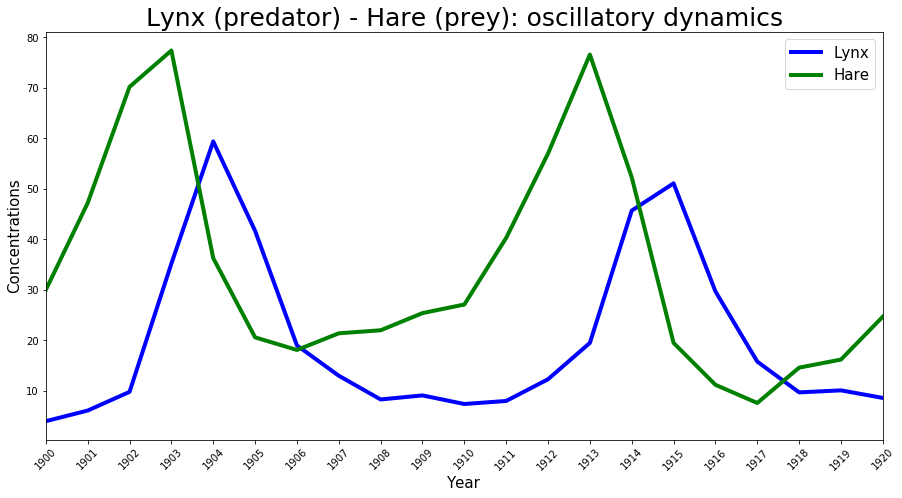

In [7]:
Year = np.arange(1900,1921,1)
Lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
Hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
plt.figure(figsize=(15, 7.5))
plt.plot(Year,Lynx,color='b', lw=4, label='Lynx')
plt.plot(Year,Hare,color='g', lw=4, label='Hare')
plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Concentrations', fontsize=15)
plt.xticks(Year,rotation=45)
plt.title('Lynx (predator) - Hare (prey): oscillatory dynamics', fontsize=25);


## The probablistic model

I have now got all the ingredients needed in order to define the probabilistic model in PyMC3. As I have mentioned previously I will set up the probabilistic model with the exact same likelihood and priors used in the STAN example. The observed data is defined as follows:

$$\log (\boldsymbol{Y(t)}) = \log (\boldsymbol{X(t)}) + \eta(t),$$ 

where $\eta(t)$ is assumed to be zero mean i.i.d Gaussian noise with an unknown standard deviation $\sigma$, that needs to be estimated. The above multiplicative (on the natural scale) noise model encodes a lognormal distribution as the likelihood:

$$\boldsymbol{Y(t)} = \mathcal{L}\mathcal{N}(\log (\boldsymbol{X(t)}), \sigma^2).$$

The following priors are then placed on the parameters:


\begin{aligned}
X(0), Y(0) &\sim  \mathcal{L}\mathcal{N}(\log(10),1),\\
\alpha, \gamma &\sim \mathcal{N}(1,0.5),\\
\beta, \delta &\sim \mathcal{N}(0.05,0.05),\\
\sigma &\sim \mathcal{L}\mathcal{N}(-1,1).
\end{aligned}

For an intuitive explanation, which I am omitting for brevity, regarding the choice of priors as well as the likelihood model, I would recommend the STAN example mentioned above. The above probabilistic model is defined in PyMC3 below. Note that the flattened state vector is reshaped to match the data dimensionality.

Finally, I use the `pm.sample` method to run NUTS and obtain $1500$ post warm-up samples from the posterior.

Text(0, 0.5, 'Value')

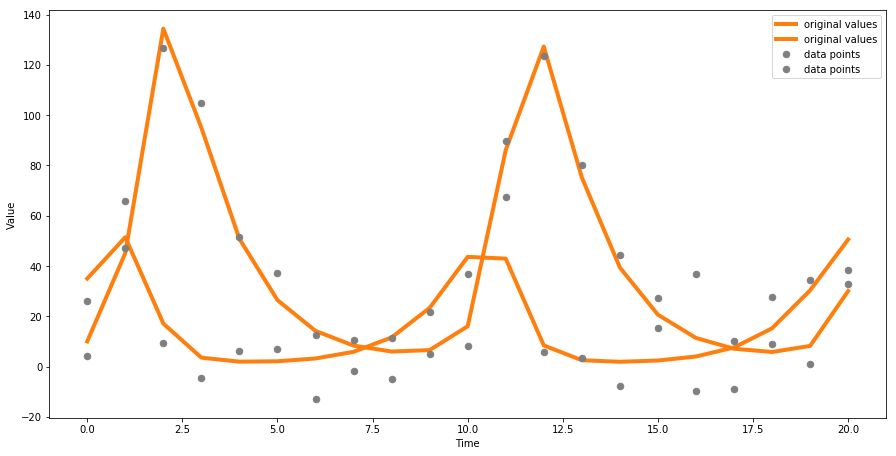

In [8]:
times = np.arange(0, 21)
sigma=10
real_params = [0.82,0.02,0.75,0.05,35,10]
sol=ode_model.simulate(real_params, times)
Ysim=sol+np.random.randn(21,2)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Ysim, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

In [27]:
# Define the data matrix
Y = np.vstack((Hare,Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)


# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    alpha =  pm.Gamma('alpha', mu=0.5,sd=1)
    beta =  pm.Beta('beta', mu=0.1,sigma=0.1)
    gamma =  pm.Gamma('gamma', mu=0.5,sd=1)
    delta = pm.Beta('delta', mu=0.1,sigma=0.1)
    
    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    sigma = pm.HalfNormal('sigma', sd=1, shape=2)

    all_params = pm.math.stack([alpha,beta,gamma,delta,xt0,yt0],axis=0)
    ode_sol = my_ODEop(all_params)
    mu = ode_sol.reshape(Y.shape)
    
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(mu), sd=sigma, observed=Y)

In [89]:
dlp = LV_model.fastdlogp()
inputlist = [np.random.randn(*x.tag.test_value.shape) for x in LV_model.free_RVs]
input_dict = {x.name: y for x, y in zip(LV_model.free_RVs, inputlist)}
dlp(input_dict)

array([ -9.98607954,  -1.86331344,  27.18152395, -17.51304788,
       -17.18504107,  12.33137493, -15.89781675, -72.30763025])

In [19]:
LV_model.free_RVs

[alpha_log__,
 beta_logodds__,
 gamma_log__,
 delta_logodds__,
 xto_log__,
 yto_log__,
 sigma_log__]

In [8]:
from pymc3.variational.approximations import (
    MeanFieldGroup, FullRankGroup,
    NormalizingFlowGroup, EmpiricalGroup,
    MeanField, FullRank, NormalizingFlow, Empirical
)
from pymc3.variational.inference import (
    ADVI, FullRankADVI, SVGD, NFVI, ASVGD,
    fit
)
import theano.tensor as tt
import pymc3 as pm
from pymc3.variational.approximations import FullRank
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

# Define the data matrix
Y = np.vstack((Hare,Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)


# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    alpha =  pm.Gamma('alpha', mu=0.5,sd=1)
    beta =  pm.Beta('beta', mu=0.1,sigma=0.1)
    gamma =  pm.Gamma('gamma', mu=0.5,sd=1)
    delta = pm.Beta('delta', mu=0.1,sigma=0.1)
    
    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    sigma = pm.HalfNormal('sigma', sd=1, shape=2)

    """


    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    #sigma = pm.Gamma('Sigma', mu=10,sd=1,shape=2)
    sigma = pm.Lognormal('sigma', mu=-1, sd=1, shape=2)
    """
    all_params = pm.math.stack([alpha,beta,gamma,delta,xt0,yt0],axis=0)
    ode_sol = my_ODEop(all_params)
    mu = ode_sol.reshape(Y.shape)
    
    #cov=np.eye(2)*sigma**2
    #Y_obs = pm.Normal('Y_obs', mu=pm.math.log(mu), sd=sigma, observed=np.log(Y))
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(mu), sd=sigma, observed=Y)
    
    start = {'alpha':0.5,'beta':0.1,'gamma':0.5,'delta':0.1,'xto':10,'yto':5,'sigma':(0.5,0.8)}#'xto':10
    """
    ### Low rank approximation to full-covariance ###
    advi=pm.NFVI('scale-hh*6-loc', jitter=0.01)#planar*2', jitter=1 '
    mu_approx = advi.approx.params[0] 
    rho_approx = advi.approx.params[1] 
    rho_approx.set_value(-1*np.ones(rho_approx.eval().shape))
    """
    
    
    advi=pm.FullRankADVI()#start=start,method='fullrank'
    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval, std=advi.approx.std.eval ) 
    rho_approx = advi.approx.params[0] 
    mu_approx = advi.approx.params[1] 
    rho_approx.set_value(0.1*np.ones(rho_approx.eval().shape)) #0.1 added to make the covariance stable
    #mu_approx.set_value(0.1*np.ones(mu_approx.eval().shape)) 
    # Here we use 5 Monte Carlo samples for the expectation
    

    q_dist = advi.fit(5000,obj_n_mc=5,
                    obj_optimizer=pm.adam(learning_rate=0.01),callbacks=[tracker])    
                  
    #trace = pm.sample(1500, tune=1000,init='adapt_diag')
    
#trace['diverging'].sum()

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home/sanmitra/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.9-64/tmpdm0akb1m/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '12969' (I am process '30438')
  0%|          | 0/5000 [00:00<?, ?it/s]/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fu

In [30]:
trace_vb = q_dist.sample(1000)
vb_params_ode = np.array([trace_vb.get_values('alpha'),trace_vb.get_values('beta'),trace_vb.get_values('gamma'),
                     trace_vb.get_values('delta'),trace_vb.get_values('xto'),trace_vb.get_values('yto')]).T
vb_params_sd = np.array(trace_vb.get_values('sigma'))
vb_params = np.concatenate((vb_params_ode,vb_params_sd),axis=1)
np.savetxt('paper_lv_vb.txt',vb_params)
vb_params.shape

/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


(1000, 8)

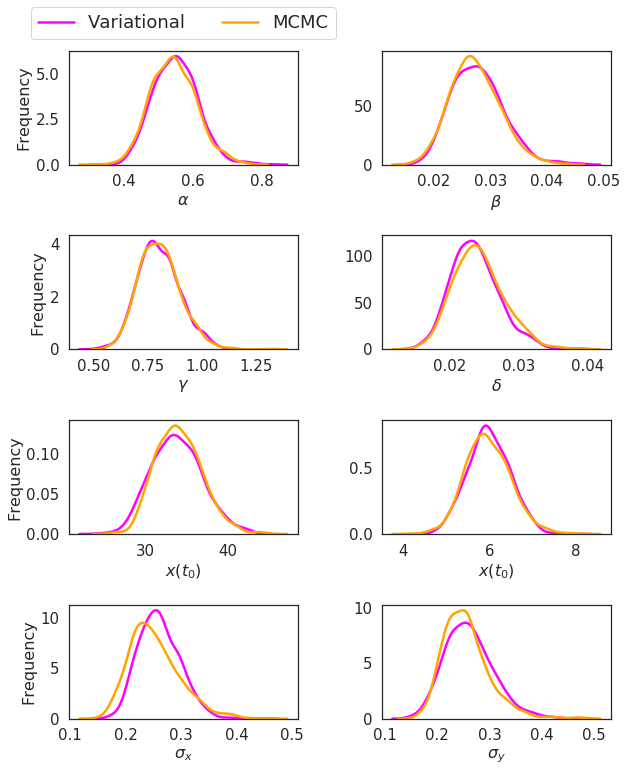

In [35]:
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,11),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")#(10,9)

param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", 
               r"$x(t_0)$", r"$x(t_0)$",r"$\sigma_x$",r"$\sigma_y$"]

for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(4, 2, i+1)
        
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params[:, i], linewidth = 2.5, color='orange')            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.savefig('lv.eps')

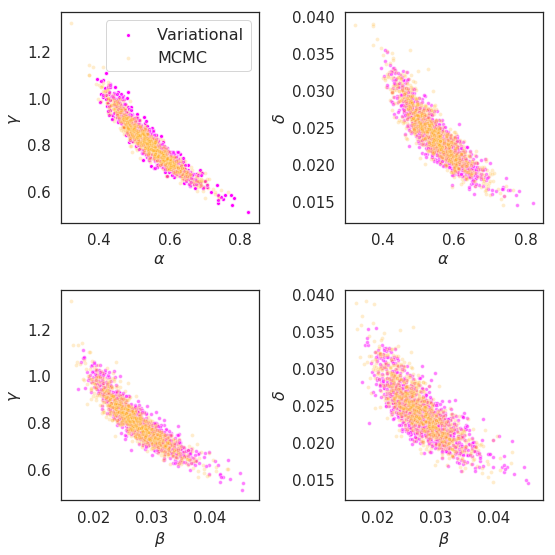

In [53]:
param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
fig_size = (8, 8)
fig, axes = plt.subplots(2, 2, figsize=fig_size)
for i in range(2):
    for j in range(2):
        if i==0 and j==0:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=1, edgecolors='none',
                            color = 'magenta', label='Variational');
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=0.5, edgecolors='none',
                            color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=0.2, edgecolors='none',
                            color = 'orange', label='MCMC');  
            axes[i,j].legend(fontsize=16)
        else:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                        ax=axes[i, j], s=15, alpha=0.5, edgecolors='none', color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+2], 
                        ax=axes[i, j], s=15, alpha=0.2, edgecolors='none', color = 'orange');
        axes[i,j].set_xlabel(param_names[i])
        axes[i,j].set_ylabel(param_names[j+2])
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.savefig('lv_pairs.eps')

In [54]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=1000, model=LV_model)['Y_obs']
mean_ppc_mc = ppc_samples.mean(axis=0)
CriL_ppc_mc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc_mc = np.percentile(ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [00:13<00:00, 71.51it/s]


In [55]:
ppc_samples = pm.sample_posterior_predictive(trace_vb, samples=1000, model=LV_model)['Y_obs']
mean_ppc_vb = ppc_samples.mean(axis=0)
CriL_ppc_vb = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc_vb = np.percentile(ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s]


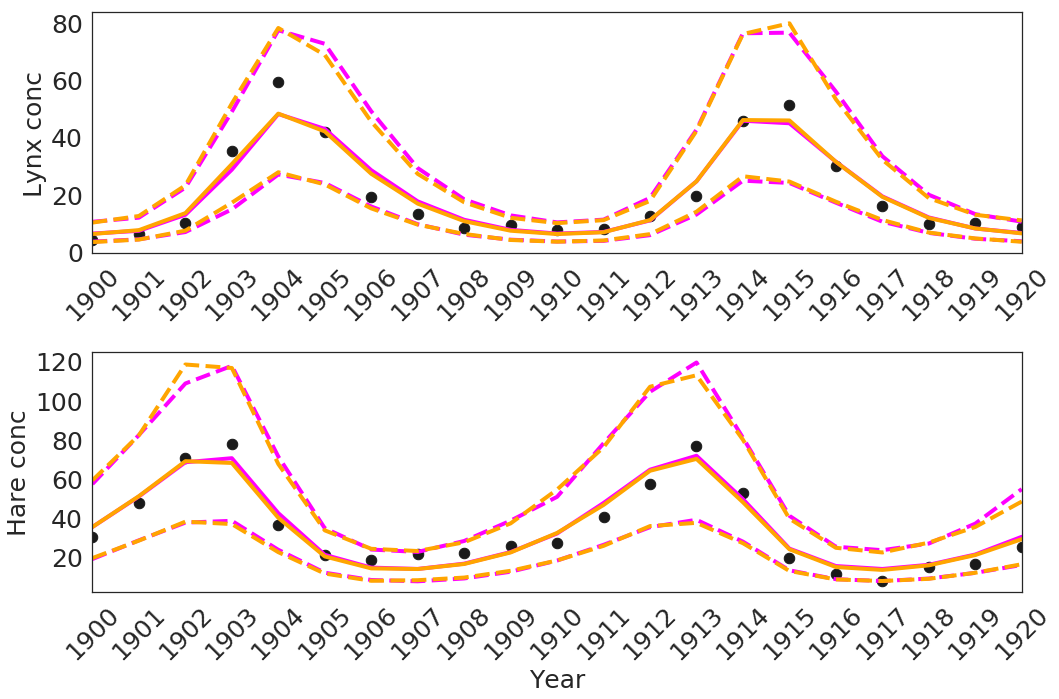

In [91]:
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(Year,Lynx,'o', color='k', lw=4, ms=10.5)
plt.plot(Year,mean_ppc_vb[:,1], color='magenta', lw=4)
plt.plot(Year,CriL_ppc_vb[:,1], '--', color='magenta', lw=4)
plt.plot(Year,CriU_ppc_vb[:,1], '--',  color='magenta', lw=4)
plt.plot(Year,mean_ppc_mc[:,1], color='orange', lw=4)
plt.plot(Year,CriL_ppc_mc[:,1], '--', color='orange', lw=4)
plt.plot(Year,CriU_ppc_mc[:,1], '--',  color='orange', lw=4)
plt.xlim([1900,1920])
plt.ylabel('Lynx conc', fontsize=25)
plt.xticks(Year,rotation=45, fontsize=25)
plt.yticks(fontsize=25)
plt.subplot(2,1,2)
plt.plot(Year,Hare,'o', color='k', lw=4, ms=10.5, label='Observed')
plt.plot(Year,mean_ppc_vb[:,0], color='magenta', lw=4, label='Mean Variational')
plt.plot(Year,CriL_ppc_vb[:,0], '--', color='magenta', lw=4, label='Credible Intervals Variational')
plt.plot(Year,CriU_ppc_vb[:,0], '--',  color='magenta', lw=4)
plt.plot(Year,mean_ppc_mc[:,0], color='orange', lw=4, label='Mean MCMC')
plt.plot(Year,CriL_ppc_mc[:,0], '--', color='orange', lw=4, label='Credible Intervals MCMC')
plt.plot(Year,CriU_ppc_mc[:,0], '--',  color='orange', lw=4)
#plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=25)
plt.ylabel('Hare conc', fontsize=25)
plt.xticks(Year,rotation=45, fontsize=25)
plt.yticks(fontsize=25)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=3,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.savefig('lv_ppc.eps')

In [9]:
with LV_model:
    trace = pm.sample(1500, tune=1000,init='adapt_diag')
    

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, yto, xto, delta, gamma, beta, alpha]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains:   0%|          | 5/10000 [00:00<03:21, 49.67draws/s]/scratch/sanmitra/conda_envs/ML-env/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun ty

In [29]:
mc_params_ode = np.array([trace.get_values('alpha'),trace.get_values('beta'),trace.get_values('gamma'),
                     trace.get_values('delta'),trace.get_values('xto'),trace.get_values('yto')]).T
mc_params_sd = np.array(trace.get_values('sigma'))
mc_params = np.concatenate((mc_params_ode,mc_params_sd),axis=1)[::6,:]
np.savetxt('paper_lv_mc.txt',mc_params)
mc_params.shape

(1000, 8)

In [21]:
import scipy.stats as stats
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_context("paper", font_scale=1)
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$"]#
def pairwise(samples1,samples2,
             ref_parameters=None,
             parameter_names=None):

    sampler = 'RWM'
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    n_sample, n_param = samples1.shape
    fig_size = (3 * n_param, 3 * n_param)
    fig, axes = plt.subplots(n_param, n_param, figsize=fig_size)

    bins = 25
    for i in range(n_param):
        for j in range(n_param):
            if i == j:
                sns.kdeplot(samples1[:, i], ax=axes[i, j], color = 'blue');
                sns.kdeplot(samples2[:, i], ax=axes[i, j], color = 'orange');               
                    
                if i==0 and j==0:
                    sns.kdeplot(samples1[:, i], ax=axes[i, j], color = 'blue',label='RWM');
                    sns.kdeplot(samples2[:, i], ax=axes[i, j], color = 'orange',label='GOLD');                       
                    axes[i, j].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2);

                # Add reference parameters if given
                if ref_parameters is not None:
                    ymin_tv, ymax_tv = axes[i, j].get_ylim()
                    axes[i, j].plot(
                        [ref_parameters[i], ref_parameters[i]],
                        [0.0, ymax_tv],
                        '--', c='k')

            elif i < j:
                axes[i, j].axis('off')

            else:
                # Lower-left: Plot the samples as density map
                

                #n_levels=30, cmap="Purples_d"

                sns.kdeplot(samples1[:, j], samples1[:, i], ax=axes[i, j], cmap=cmap, n_levels=30, shade=True);
                sns.scatterplot(
                    samples2[:, j], samples2[:, i], ax=axes[i, j], s=10, alpha=0.2, edgecolors='none', color = 'orange');
            

            if i < n_param - 1:
                axes[i, j].set_xticklabels([])
            else:
                for tl in axes[i, j].get_xticklabels():
                    tl.set_rotation(45)

            if j > 0:
                axes[i, j].set_yticklabels([])

        if parameter_names is not None:
            axes[-1, i].set_xlabel(parameter_names[i])
            
        else:
            axes[-1, i].set_xlabel('Parameter %d' % (i + 1))
        if i == 0:
            axes[i, 0].set_ylabel('Frequency')
        else:
            if parameter_names is not None:
                axes[i, 0].set_ylabel(parameter_names[i])
            else:
                axes[i, 0].set_ylabel('Parameter %d' % (i + 1))
                
                            

    return fig, axes

(<Figure size 1296x1296 with 36 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad8be00358>,
       dtype=object))

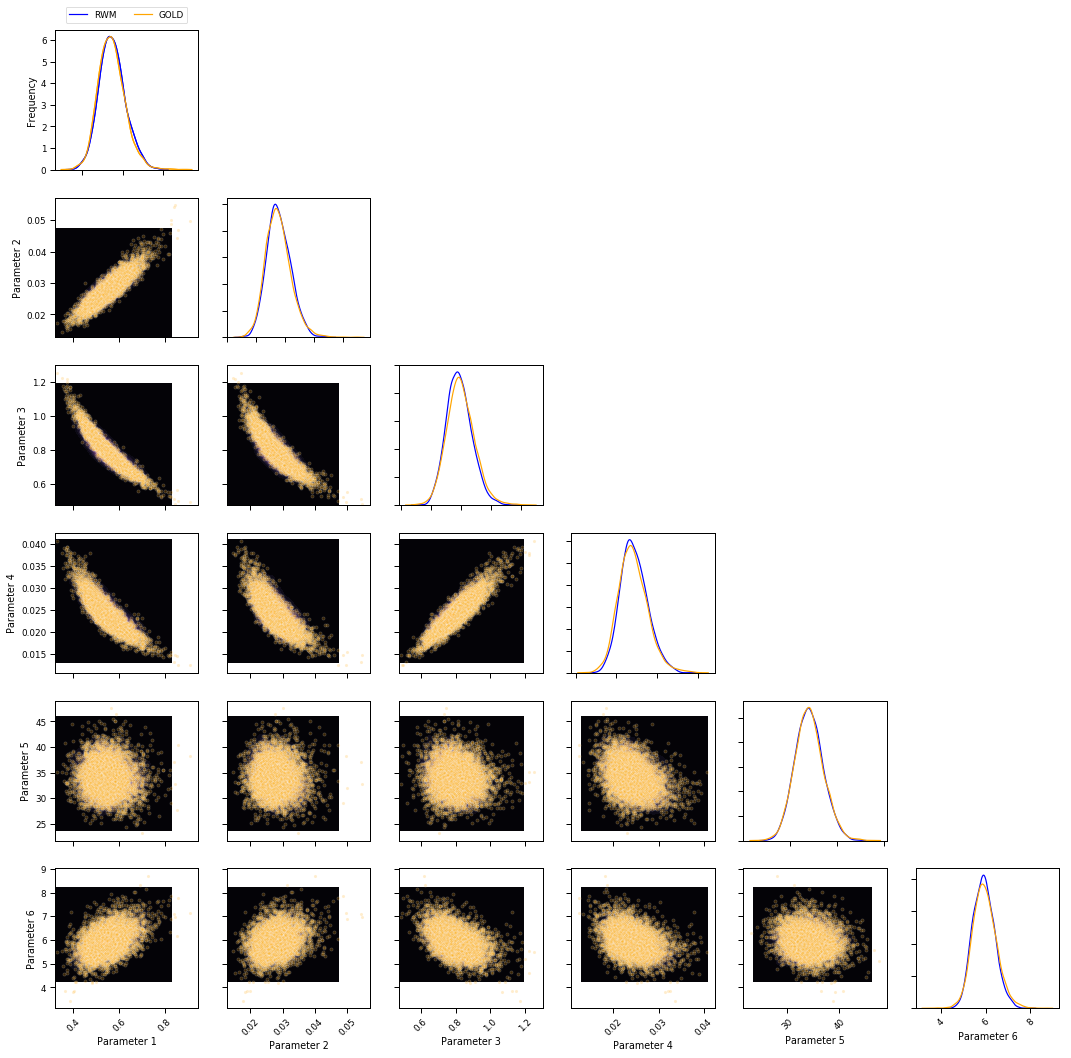

In [22]:
pairwise(vb_params,mcmc_params)

In [24]:
np.savetxt('lv_vb.txt',vb_params)
np.savetxt('lv_mc.txt',mcmc_params)